In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

from quilt.data.examples import prophet as pdata

In [2]:
# feature eng: log scale
df = pdata.peyton_manning()
df['y'] = np.log(df['y'])

Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the add_seasonality method (Python) or function (R).

The inputs to this function are a name, the period of the seasonality in days, and the number of Fourier terms for the seasonality. Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting: $N$ Fourier terms corresponds to $2N$ variables used for modeling the cycle. For reference, by default Prophet uses 3 terms for weekly seasonality and 10 for yearly seasonality. An optional input to add_seasonality is the prior scale for that seasonal component - this is discussed below.

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/karve/anaconda3/envs/dev/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


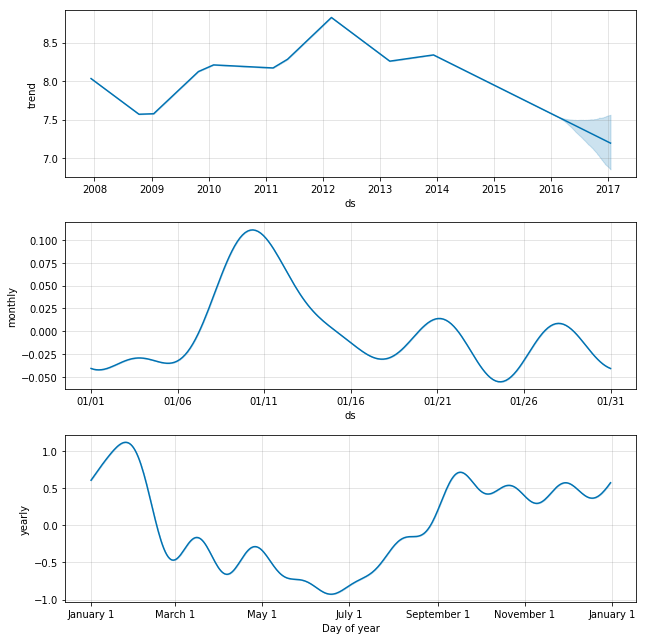

In [3]:
# empty model
m = Prophet(weekly_seasonality=False)
# add seasonality before fitting
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
# fit
m.fit(df)
# future
future = m.make_future_dataframe(periods=365)
# do the forecast
forecast = m.predict(future)
# show it
%matplotlib inline
m.plot_components(forecast);

# Holidays and special events
Make a data frame with two columns: `holiday, ds`.

If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them. It has two columns (holiday and ds) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won’t repeat in the future, Prophet will model them and then not include them in the forecast.

In [4]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [5]:
print(Prophet.__doc__)

Prophet forecaster.

    Parameters
    ----------
    growth: String 'linear' or 'logistic' to specify a linear or logistic
        trend.
    changepoints: List of dates at which to include potential changepoints. If
        not specified, potential changepoints are selected automatically.
    n_changepoints: Number of potential changepoints to include. Not used
        if input `changepoints` is supplied. If `changepoints` is not supplied,
        then n_changepoints potential changepoints are selected uniformly from
        the first 80 percent of the history.
    yearly_seasonality: Fit yearly seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    weekly_seasonality: Fit weekly seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    daily_seasonality: Fit daily seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    holidays: pd.DataFrame with columns holiday (stri

In [6]:
m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/karve/anaconda3/envs/dev/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [7]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.223925,1.199984
2191,2014-02-03,1.901619,1.458839
2532,2015-01-11,1.223925,0.000000
2533,2015-01-12,1.901619,0.000000
2901,2016-01-17,1.223925,0.000000
2902,2016-01-18,1.901619,0.000000
2908,2016-01-24,1.223925,0.000000
2909,2016-01-25,1.901619,0.000000
2922,2016-02-07,1.223925,1.199984
2923,2016-02-08,1.901619,1.458839


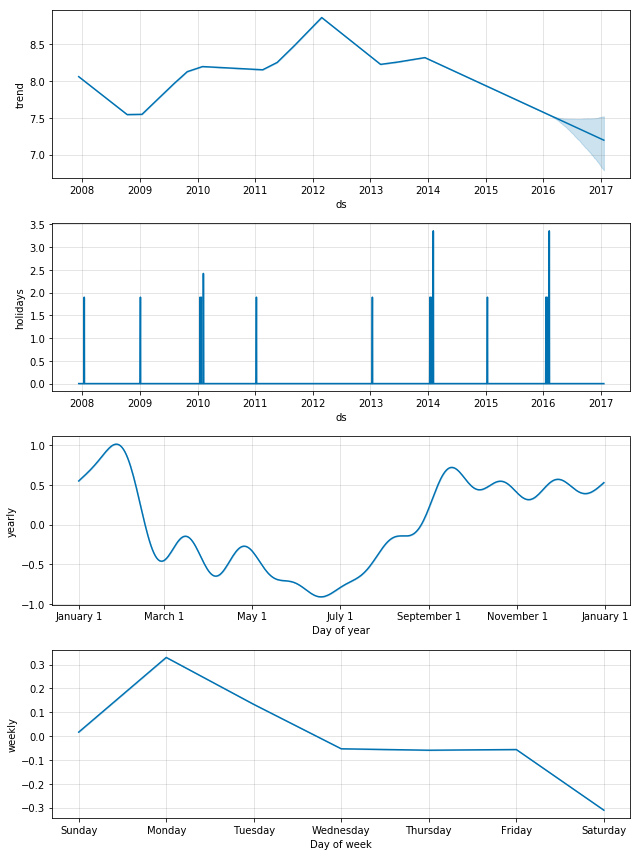

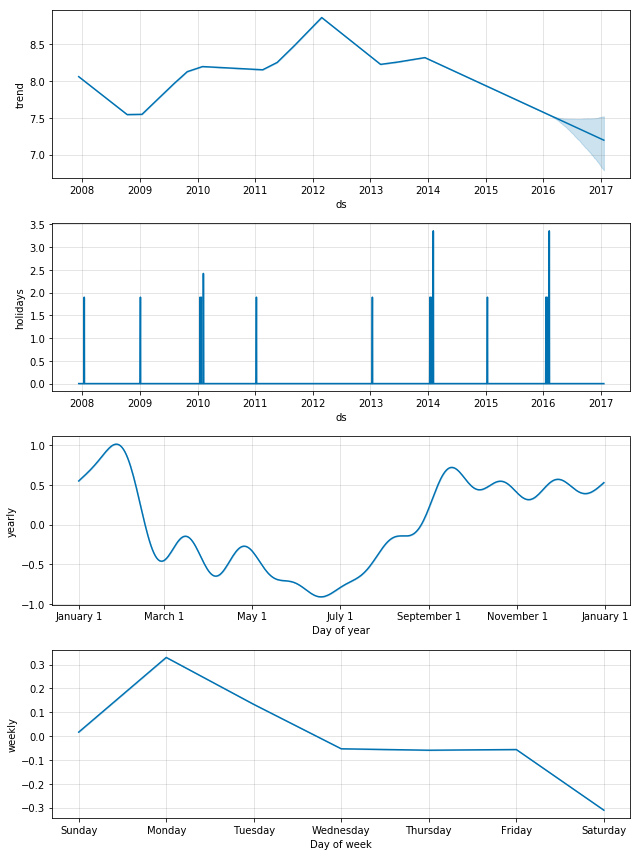

In [8]:
m.plot_components(forecast)

If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using the parameter holidays_prior_scale. By default this parameter is 10, which provides very little regularization. Reducing this parameter dampens holiday effects:

In [9]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/karve/anaconda3/envs/dev/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,playoff,superbowl
2190,2014-02-02,1.207366,0.960616
2191,2014-02-03,1.854605,0.991431
2532,2015-01-11,1.207366,0.000000
2533,2015-01-12,1.854605,0.000000
2901,2016-01-17,1.207366,0.000000
2902,2016-01-18,1.854605,0.000000
2908,2016-01-24,1.207366,0.000000
2909,2016-01-25,1.854605,0.000000
2922,2016-02-07,1.207366,0.960616
2923,2016-02-08,1.854605,0.991431


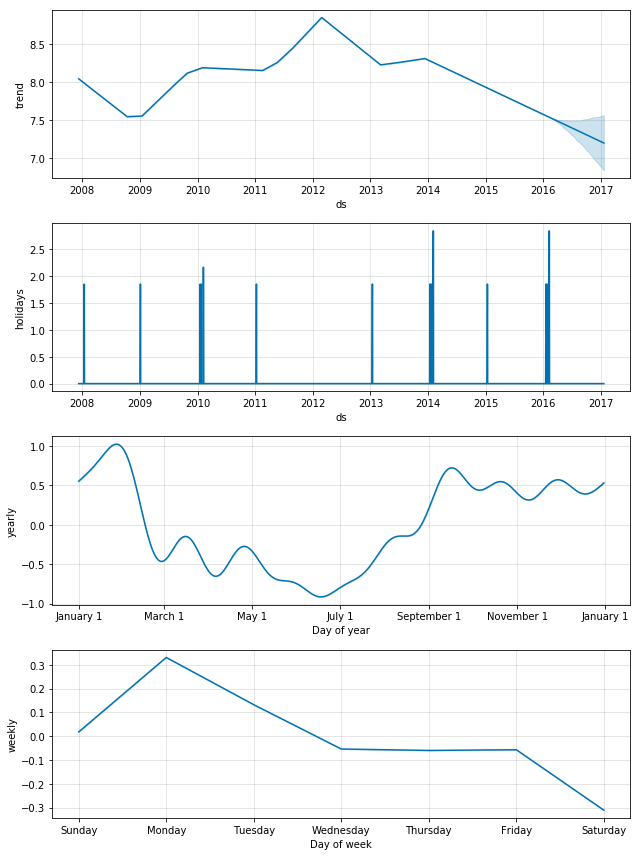

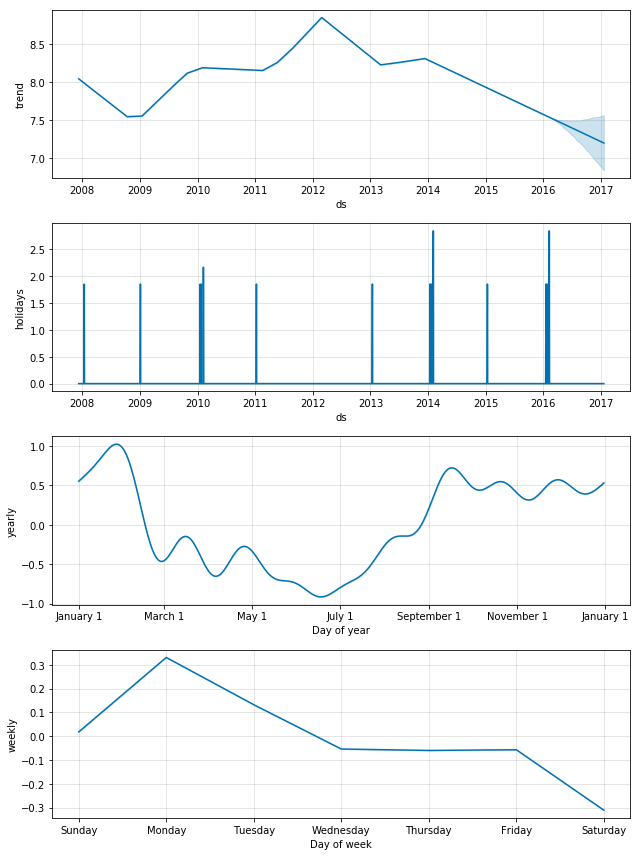

In [10]:
m.plot_components(forecast)

Adjusting seasonality for individual 

In [11]:
m = Prophet()
m.add_seasonality(
    name='weekly', period=7, fourier_order=3, prior_scale=0.1);


* `add_regressor` is more general than `holidays=`; (does not require binary data)
* can use another time series as the regressor

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/karve/anaconda3/envs/dev/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


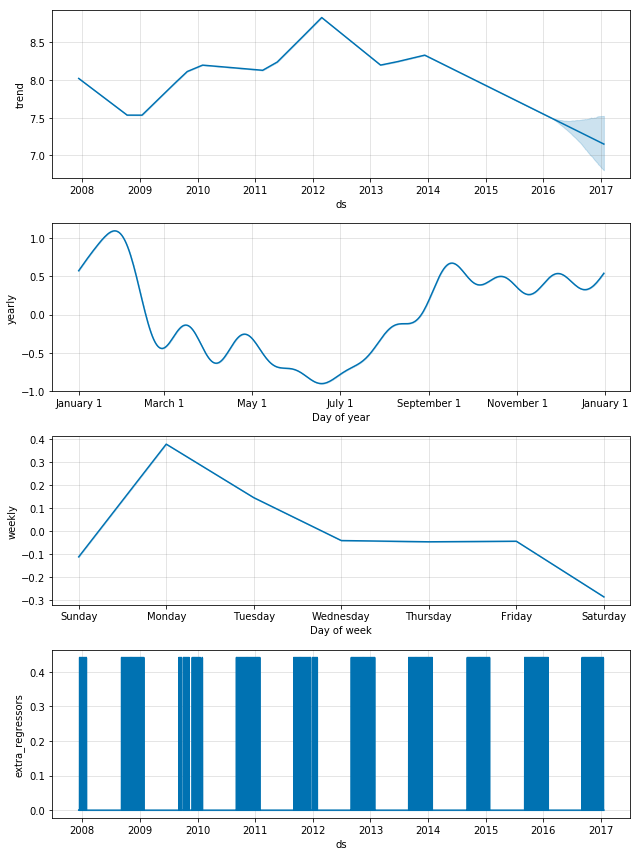

In [12]:


def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
m.plot_components(forecast);